# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [1]:
import os
import time

wait_to_make = "trained_list/roberta-large.txt"
count = 0
while 1:
    if os.path.exists(wait_to_make):
        break
    print(f'sleep {count} h')
    time.sleep(3600)
    count+=1
    


In [2]:
EXP_NAME = "microsoft-mpnet-base-attention2"


In [3]:
# !nvidia-smi

In [4]:
# ! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [5]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================

import os
import datetime

INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'

OUTPUT_DIR = f'./output/{EXP_NAME}/'
# if not os.path.exists(OUTPUT_DIR):
os.makedirs(OUTPUT_DIR, exist_ok=True)


# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    # model="microsoft/deberta-v3-large"
    model = "microsoft/mpnet-base"
    # size = "large
    # model = f"{model}-{size}"
    if "small" in model:
        hidden_state = hiddden_state_fix = 512
    elif "base" in model:
        hidden_state = hiddden_state_fix = 768
    elif "large" in model:
        hidden_state = hiddden_state_fix = 1024
    elif "xlarge" in model:
        hidden_state =  1536
        
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=8
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    
    batch_size=8
    
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[i for i in range(n_fold)]
    train=True
    pass_fold = [0]
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [8]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [9]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0

# Library

In [10]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

start = time.time()

torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.6
transformers.__version__: 4.17.0
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [11]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [12]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [13]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR+'CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [14]:
pad = "[SEP]"
train['text'] = train['anchor'] + pad + train['target'] +pad  + train['context_text']
test['text'] = test['anchor'] + pad + test['target'] +pad  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

<AxesSubplot:>

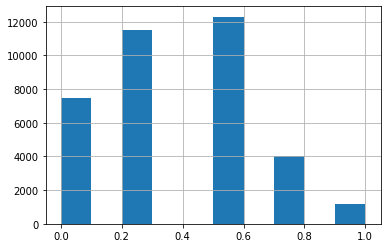

In [15]:
train['score'].hist()

In [16]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [17]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [18]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [19]:
# !pip install --no-cache-dir sentencepiece

In [20]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer



In [21]:
# CFG.tokenizer = AutoTokenizer.from_pretrained(OUTPUT_DIR+'tokenizer/')
# CFG.tokenizer
AutoTokenizer.from_pretrained(OUTPUT_DIR+'tokenizer/')

PreTrainedTokenizerFast(name_or_path='./output/microsoft-mpnet-base-attention2/tokenizer/', vocab_size=30527, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

# Dataset

In [22]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 125


In [23]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

sys.path.append('../dataset')
from dataset import TrainDataset

torch.__version__: 1.9.0+cu111


In [24]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [25]:
# # ====================================================
# # Model
# # ====================================================
# class CustomModel(nn.Module):
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
#         self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
#         self._init_weights(self.fc)
#         self.attention = nn.Sequential(
#             nn.Linear(self.config.hidden_size, 512),
#             nn.Tanh(),
#             nn.Linear(512, 1),
#             nn.Softmax(dim=1)
#         )
#         self._init_weights(self.attention)
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         last_hidden_states = outputs[0]
#         # feature = torch.mean(last_hidden_states, 1)
#         weights = self.attention(last_hidden_states)
#         feature = torch.sum(weights * last_hidden_states, dim=1)
#         return feature

#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         output = self.fc(self.fc_dropout(feature))
#         return output
    


In [26]:
class CustomModel2(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
            token_embeddings_size = len(CFG.tokenizer)
            self.model.resize_token_embeddings(token_embeddings_size)
        else:
            self.model = AutoModel.from_config(self.config)

        self.fc_dropout1 = nn.Dropout(0.1)
        self.fc_dropout2 = nn.Dropout(0.2)
        self.fc_dropout3 = nn.Dropout(0.3)
        self.fc_dropout4 = nn.Dropout(0.4)
        self.fc_dropout5 = nn.Dropout(0.5)

        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        # これがいわゆるattention pool
        # https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/discussion/324330
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, self.config.hidden_size),
            nn.LayerNorm(self.config.hidden_size),
            nn.GELU(),
            nn.Linear(self.config.hidden_size, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)

        feature1 = self.fc_dropout1(feature)
        feature2 = self.fc_dropout2(feature)
        feature3 = self.fc_dropout3(feature)
        feature4 = self.fc_dropout4(feature)
        feature5 = self.fc_dropout5(feature)

        feature_all = (feature1+feature2+feature3+feature4+feature5)/5
        output = self.fc(feature_all)
        
        return output

# Helpler functions

In [27]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [28]:
# ====================================================
# train loop
# ====================================================
# def train_loop(folds, fold):
def train_loop(train_loader, valid_loader):
#     LOGGER.info(f"========== fold: {fold} training ==========")

#     # ====================================================
#     # loader
#     # ====================================================
#     train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
#     valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
#     valid_labels = valid_folds['score'].values
    
#     train_dataset = TrainDataset(CFG, train_folds)
#     valid_dataset = TrainDataset(CFG, valid_folds)

#     train_loader = DataLoader(train_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=True,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=False,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel2(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [29]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            # if fold in CFG.pass_fold:
            #     continue
            LOGGER.info(f"========== fold: {fold} training ==========")
            print(f"\033[38;5;40m========== fold: {fold} training ==========\033[0m");
            if fold in CFG.trn_fold:
                # ====================================================
                # loader
                # ====================================================
                folds = train
                train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
                valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
                valid_labels = valid_folds['score'].values

                train_dataset = TrainDataset(CFG, train_folds)
                valid_dataset = TrainDataset(CFG, valid_folds)

                train_loader = DataLoader(train_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=False,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#                 _oof_df = train_loop(train, fold)
                _oof_df = train_loop(train_loader, valid_loader)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


========== fold: 0 training ==========


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

Epoch: [1][0/3419] Elapsed 0m 0s (remain 49m 13s) Loss: 0.7010(0.7010) Grad: 46722.9570  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 12s (remain 6m 45s) Loss: 0.6893(0.6608) Grad: 16552.1035  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 0m 23s (remain 6m 21s) Loss: 0.5358(0.6385) Grad: 33124.3398  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 0m 35s (remain 6m 9s) Loss: 0.7036(0.6296) Grad: 24704.6660  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 0m 47s (remain 5m 54s) Loss: 0.6383(0.6239) Grad: 40122.3555  LR: 0.00001999  
Epoch: [1][500/3419] Elapsed 0m 58s (remain 5m 41s) Loss: 0.5984(0.6192) Grad: 15346.1602  LR: 0.00001998  
Epoch: [1][600/3419] Elapsed 1m 10s (remain 5m 28s) Loss: 0.6679(0.6172) Grad: 31337.5918  LR: 0.00001998  
Epoch: [1][700/3419] Elapsed 1m 21s (remain 5m 16s) Loss: 0.4808(0.6151) Grad: 24542.0254  LR: 0.00001997  
Epoch: [1][800/3419] Elapsed 1m 33s (remain 5m 4s) Loss: 0.6392(0.6129) Grad: 29155.2188  LR: 0.00001996  
Epoch: [1][900/3419] Elapsed 1m 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 2m 59s) Loss: 0.5649(0.5649) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/1140] Elapsed 0m 2s (remain 0m 29s) Loss: 0.5717(0.5511) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.4466(0.5532) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.7650(0.5534) 
EVAL: [400/1140] Elapsed 0m 10s (remain 0m 20s) Loss: 0.4941(0.5540) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.5931(0.5596) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 14s) Loss: 0.5508(0.5588) 
EVAL: [700/1140] Elapsed 0m 18s (remain 0m 11s) Loss: 0.6467(0.5597) 
EVAL: [800/1140] Elapsed 0m 21s (remain 0m 9s) Loss: 0.6676(0.5585) 
EVAL: [900/1140] Elapsed 0m 24s (remain 0m 6s) Loss: 0.4460(0.5573) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.5484(0.5587) 
EVAL: [1100/1140] Elapsed 0m 29s (remain 0m 1s) Loss: 0.6012(0.5587) 


Epoch 1 - avg_train_loss: 0.5840  avg_val_loss: 0.5582  time: 439s
Epoch 1 - Score: 0.7844
Epoch 1 - Save Best Score: 0.7844 Model


EVAL: [1139/1140] Elapsed 0m 30s (remain 0m 0s) Loss: 0.6191(0.5582) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 19m 13s) Loss: 0.4994(0.4994) Grad: 43704.1211  LR: 0.00001924  
Epoch: [2][100/3419] Elapsed 0m 11s (remain 6m 17s) Loss: 0.4119(0.5430) Grad: 35575.1211  LR: 0.00001919  
Epoch: [2][200/3419] Elapsed 0m 24s (remain 6m 24s) Loss: 0.6923(0.5556) Grad: 41070.1016  LR: 0.00001915  
Epoch: [2][300/3419] Elapsed 0m 35s (remain 6m 4s) Loss: 0.5053(0.5526) Grad: 56140.1875  LR: 0.00001910  
Epoch: [2][400/3419] Elapsed 0m 46s (remain 5m 48s) Loss: 0.5625(0.5569) Grad: 99907.3750  LR: 0.00001905  
Epoch: [2][500/3419] Elapsed 0m 57s (remain 5m 34s) Loss: 0.4121(0.5562) Grad: 27818.6719  LR: 0.00001900  
Epoch: [2][600/3419] Elapsed 1m 8s (remain 5m 21s) Loss: 0.5093(0.5572) Grad: 83445.5000  LR: 0.00001895  
Epoch: [2][700/3419] Elapsed 1m 19s (remain 5m 9s) Loss: 0.6562(0.5573) Grad: 163460.6406  LR: 0.00001890  
Epoch: [2][800/3419] Elapsed 1m 30s (remain 4m 57s) Loss: 0.5493(0.5559) Grad: 88863.4219  LR: 0.00001885  
Epoch: [2][900/3419] Elapsed 1m 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][3418/3419] Elapsed 6m 41s (remain 0m 0s) Loss: 0.3431(0.5543) Grad: 8561.6152  LR: 0.00001707  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 2m 56s) Loss: 0.5779(0.5779) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/1140] Elapsed 0m 3s (remain 0m 31s) Loss: 0.5466(0.5539) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 27s) Loss: 0.4686(0.5567) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 24s) Loss: 0.7631(0.5574) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 21s) Loss: 0.5047(0.5579) 
EVAL: [500/1140] Elapsed 0m 14s (remain 0m 18s) Loss: 0.5980(0.5638) 
EVAL: [600/1140] Elapsed 0m 17s (remain 0m 15s) Loss: 0.5794(0.5619) 
EVAL: [700/1140] Elapsed 0m 20s (remain 0m 12s) Loss: 0.6557(0.5630) 
EVAL: [800/1140] Elapsed 0m 23s (remain 0m 9s) Loss: 0.6783(0.5623) 
EVAL: [900/1140] Elapsed 0m 26s (remain 0m 6s) Loss: 0.4201(0.5610) 
EVAL: [1000/1140] Elapsed 0m 29s (remain 0m 4s) Loss: 0.5418(0.5624) 
EVAL: [1100/1140] Elapsed 0m 32s (remain 0m 1s) Loss: 0.5091(0.5616) 


Epoch 2 - avg_train_loss: 0.5543  avg_val_loss: 0.5613  time: 435s
Epoch 2 - Score: 0.7865
Epoch 2 - Save Best Score: 0.7865 Model


EVAL: [1139/1140] Elapsed 0m 33s (remain 0m 0s) Loss: 0.6177(0.5613) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 19m 35s) Loss: 0.5698(0.5698) Grad: 27960.3125  LR: 0.00001707  
Epoch: [3][100/3419] Elapsed 0m 12s (remain 6m 43s) Loss: 0.4732(0.5460) Grad: 20881.4766  LR: 0.00001699  
Epoch: [3][200/3419] Elapsed 0m 24s (remain 6m 28s) Loss: 0.4909(0.5420) Grad: 51819.8398  LR: 0.00001691  
Epoch: [3][300/3419] Elapsed 0m 36s (remain 6m 15s) Loss: 0.4702(0.5384) Grad: 122644.5234  LR: 0.00001682  
Epoch: [3][400/3419] Elapsed 0m 48s (remain 6m 2s) Loss: 0.5804(0.5387) Grad: 52030.0781  LR: 0.00001674  
Epoch: [3][500/3419] Elapsed 0m 59s (remain 5m 48s) Loss: 0.7213(0.5429) Grad: 77228.0156  LR: 0.00001665  
Epoch: [3][600/3419] Elapsed 1m 11s (remain 5m 33s) Loss: 0.5357(0.5436) Grad: 29091.5625  LR: 0.00001657  
Epoch: [3][700/3419] Elapsed 1m 23s (remain 5m 22s) Loss: 0.6492(0.5423) Grad: 11278.7734  LR: 0.00001648  
Epoch: [3][800/3419] Elapsed 1m 35s (remain 5m 11s) Loss: 0.5135(0.5425) Grad: 10963.2207  LR: 0.00001639  
Epoch: [3][900/3419] Elapsed 1

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 2m 56s) Loss: 0.6069(0.6069) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/1140] Elapsed 0m 2s (remain 0m 29s) Loss: 0.6353(0.5525) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.4477(0.5550) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.7972(0.5521) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 20s) Loss: 0.4931(0.5519) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.5762(0.5568) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 14s) Loss: 0.5678(0.5558) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 12s) Loss: 0.6347(0.5563) 
EVAL: [800/1140] Elapsed 0m 22s (remain 0m 9s) Loss: 0.6846(0.5547) 
EVAL: [900/1140] Elapsed 0m 24s (remain 0m 6s) Loss: 0.4367(0.5538) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.5508(0.5547) 
EVAL: [1100/1140] Elapsed 0m 30s (remain 0m 1s) Loss: 0.5125(0.5541) 


Epoch 3 - avg_train_loss: 0.5382  avg_val_loss: 0.5539  time: 433s
Epoch 3 - Score: 0.8093
Epoch 3 - Save Best Score: 0.8093 Model


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.6103(0.5539) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 26m 20s) Loss: 0.5485(0.5485) Grad: 66531.4766  LR: 0.00001383  
Epoch: [4][100/3419] Elapsed 0m 11s (remain 6m 24s) Loss: 0.5100(0.5165) Grad: 53896.4453  LR: 0.00001372  
Epoch: [4][200/3419] Elapsed 0m 22s (remain 6m 7s) Loss: 0.3752(0.5121) Grad: 31751.2637  LR: 0.00001361  
Epoch: [4][300/3419] Elapsed 0m 34s (remain 5m 56s) Loss: 0.5894(0.5198) Grad: 15917.5547  LR: 0.00001351  
Epoch: [4][400/3419] Elapsed 0m 45s (remain 5m 43s) Loss: 0.5952(0.5170) Grad: 74974.0781  LR: 0.00001340  
Epoch: [4][500/3419] Elapsed 0m 56s (remain 5m 30s) Loss: 0.4925(0.5189) Grad: 30209.7617  LR: 0.00001329  
Epoch: [4][600/3419] Elapsed 1m 8s (remain 5m 20s) Loss: 0.8671(0.5179) Grad: 31474.0938  LR: 0.00001318  
Epoch: [4][700/3419] Elapsed 1m 19s (remain 5m 9s) Loss: 0.5831(0.5196) Grad: 10481.5049  LR: 0.00001307  
Epoch: [4][800/3419] Elapsed 1m 31s (remain 4m 58s) Loss: 0.5050(0.5199) Grad: 63293.3594  LR: 0.00001296  
Epoch: [4][900/3419] Elapsed 1m 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][3418/3419] Elapsed 6m 41s (remain 0m 0s) Loss: 0.6532(0.5243) Grad: 22775.8320  LR: 0.00001000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 2m 56s) Loss: 0.4880(0.4880) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/1140] Elapsed 0m 3s (remain 0m 34s) Loss: 0.5809(0.5478) 
EVAL: [200/1140] Elapsed 0m 6s (remain 0m 28s) Loss: 0.4266(0.5487) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 24s) Loss: 0.8717(0.5476) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 21s) Loss: 0.5103(0.5482) 
EVAL: [500/1140] Elapsed 0m 14s (remain 0m 18s) Loss: 0.5686(0.5537) 
EVAL: [600/1140] Elapsed 0m 17s (remain 0m 15s) Loss: 0.5705(0.5519) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 12s) Loss: 0.6480(0.5530) 
EVAL: [800/1140] Elapsed 0m 22s (remain 0m 9s) Loss: 0.7468(0.5520) 
EVAL: [900/1140] Elapsed 0m 25s (remain 0m 6s) Loss: 0.4108(0.5509) 
EVAL: [1000/1140] Elapsed 0m 28s (remain 0m 3s) Loss: 0.5434(0.5521) 
EVAL: [1100/1140] Elapsed 0m 31s (remain 0m 1s) Loss: 0.5179(0.5510) 


Epoch 4 - avg_train_loss: 0.5243  avg_val_loss: 0.5508  time: 434s
Epoch 4 - Score: 0.8187
Epoch 4 - Save Best Score: 0.8187 Model


EVAL: [1139/1140] Elapsed 0m 32s (remain 0m 0s) Loss: 0.6215(0.5508) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 31m 2s) Loss: 0.7024(0.7024) Grad: 149468.1406  LR: 0.00001000  
Epoch: [5][100/3419] Elapsed 0m 11s (remain 6m 26s) Loss: 0.6923(0.5142) Grad: 20252.4453  LR: 0.00000989  
Epoch: [5][200/3419] Elapsed 0m 23s (remain 6m 8s) Loss: 0.5014(0.5152) Grad: 48544.8242  LR: 0.00000977  
Epoch: [5][300/3419] Elapsed 0m 34s (remain 5m 55s) Loss: 0.3437(0.5179) Grad: 68510.0859  LR: 0.00000966  
Epoch: [5][400/3419] Elapsed 0m 45s (remain 5m 42s) Loss: 0.4079(0.5166) Grad: 76380.5859  LR: 0.00000954  
Epoch: [5][500/3419] Elapsed 0m 56s (remain 5m 30s) Loss: 0.3295(0.5170) Grad: 9360.6045  LR: 0.00000943  
Epoch: [5][600/3419] Elapsed 1m 8s (remain 5m 18s) Loss: 0.5508(0.5184) Grad: 7283.2231  LR: 0.00000931  
Epoch: [5][700/3419] Elapsed 1m 19s (remain 5m 7s) Loss: 0.3959(0.5159) Grad: 1916.1466  LR: 0.00000920  
Epoch: [5][800/3419] Elapsed 1m 30s (remain 4m 55s) Loss: 0.5140(0.5176) Grad: 16784.0918  LR: 0.00000908  
Epoch: [5][900/3419] Elapsed 1m 41s 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 0s) Loss: 0.5188(0.5188) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/1140] Elapsed 0m 2s (remain 0m 30s) Loss: 0.5488(0.5447) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.4249(0.5570) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.7484(0.5518) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 20s) Loss: 0.4884(0.5522) 
EVAL: [500/1140] Elapsed 0m 14s (remain 0m 17s) Loss: 0.5638(0.5569) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 15s) Loss: 0.5314(0.5540) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 12s) Loss: 0.6410(0.5554) 
EVAL: [800/1140] Elapsed 0m 22s (remain 0m 9s) Loss: 0.8311(0.5549) 
EVAL: [900/1140] Elapsed 0m 25s (remain 0m 6s) Loss: 0.4063(0.5535) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.4818(0.5550) 
EVAL: [1100/1140] Elapsed 0m 30s (remain 0m 1s) Loss: 0.5131(0.5535) 


Epoch 5 - avg_train_loss: 0.5191  avg_val_loss: 0.5530  time: 420s
Epoch 5 - Score: 0.8244
Epoch 5 - Save Best Score: 0.8244 Model


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.6035(0.5530) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 25m 56s) Loss: 0.2791(0.2791) Grad: 46527.8086  LR: 0.00000617  
Epoch: [6][100/3419] Elapsed 0m 11s (remain 6m 30s) Loss: 0.5449(0.5279) Grad: 7231.3613  LR: 0.00000607  
Epoch: [6][200/3419] Elapsed 0m 23s (remain 6m 13s) Loss: 0.4148(0.5147) Grad: 37713.5156  LR: 0.00000596  
Epoch: [6][300/3419] Elapsed 0m 34s (remain 5m 59s) Loss: 0.5871(0.5142) Grad: 17138.8945  LR: 0.00000586  
Epoch: [6][400/3419] Elapsed 0m 46s (remain 5m 47s) Loss: 0.5343(0.5130) Grad: 21677.8477  LR: 0.00000575  
Epoch: [6][500/3419] Elapsed 0m 57s (remain 5m 35s) Loss: 0.5167(0.5113) Grad: 12080.1738  LR: 0.00000565  
Epoch: [6][600/3419] Elapsed 1m 9s (remain 5m 23s) Loss: 0.5565(0.5116) Grad: 13265.5010  LR: 0.00000555  
Epoch: [6][700/3419] Elapsed 1m 20s (remain 5m 12s) Loss: 0.5593(0.5131) Grad: 20715.6133  LR: 0.00000544  
Epoch: [6][800/3419] Elapsed 1m 31s (remain 5m 0s) Loss: 0.5635(0.5133) Grad: 11573.6846  LR: 0.00000534  
Epoch: [6][900/3419] Elapsed 1m 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 2s) Loss: 0.5089(0.5089) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/1140] Elapsed 0m 2s (remain 0m 30s) Loss: 0.5605(0.5459) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.4225(0.5521) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.7563(0.5459) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 20s) Loss: 0.4935(0.5469) 
EVAL: [500/1140] Elapsed 0m 14s (remain 0m 18s) Loss: 0.5646(0.5521) 
EVAL: [600/1140] Elapsed 0m 17s (remain 0m 15s) Loss: 0.5296(0.5508) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 12s) Loss: 0.6271(0.5527) 
EVAL: [800/1140] Elapsed 0m 22s (remain 0m 9s) Loss: 0.7157(0.5515) 
EVAL: [900/1140] Elapsed 0m 25s (remain 0m 6s) Loss: 0.4047(0.5503) 
EVAL: [1000/1140] Elapsed 0m 28s (remain 0m 3s) Loss: 0.5130(0.5519) 
EVAL: [1100/1140] Elapsed 0m 31s (remain 0m 1s) Loss: 0.4797(0.5502) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch 6 - avg_train_loss: 0.5098  avg_val_loss: 0.5499  time: 424s
Epoch 6 - Score: 0.8298
Epoch 6 - Save Best Score: 0.8298 Model


EVAL: [1139/1140] Elapsed 0m 32s (remain 0m 0s) Loss: 0.6019(0.5499) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][0/3419] Elapsed 0m 0s (remain 23m 32s) Loss: 0.5016(0.5016) Grad: 58075.9688  LR: 0.00000293  
Epoch: [7][100/3419] Elapsed 0m 11s (remain 6m 28s) Loss: 0.4550(0.5080) Grad: 394050.9062  LR: 0.00000285  
Epoch: [7][200/3419] Elapsed 0m 23s (remain 6m 15s) Loss: 0.4909(0.4988) Grad: 9954.2705  LR: 0.00000277  
Epoch: [7][300/3419] Elapsed 0m 35s (remain 6m 3s) Loss: 0.5836(0.4962) Grad: 84751.1406  LR: 0.00000269  
Epoch: [7][400/3419] Elapsed 0m 46s (remain 5m 52s) Loss: 0.4794(0.4963) Grad: 31809.8457  LR: 0.00000261  
Epoch: [7][500/3419] Elapsed 0m 58s (remain 5m 39s) Loss: 0.5623(0.4968) Grad: 11014.0586  LR: 0.00000254  
Epoch: [7][600/3419] Elapsed 1m 9s (remain 5m 27s) Loss: 0.4998(0.5006) Grad: 43819.5234  LR: 0.00000246  
Epoch: [7][700/3419] Elapsed 1m 21s (remain 5m 14s) Loss: 0.6233(0.5002) Grad: 33710.2305  LR: 0.00000238  
Epoch: [7][800/3419] Elapsed 1m 32s (remain 5m 2s) Loss: 0.5389(0.4991) Grad: 16596.6152  LR: 0.00000231  
Epoch: [7][900/3419] Elapsed 1m 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 0s) Loss: 0.5128(0.5128) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/1140] Elapsed 0m 2s (remain 0m 30s) Loss: 0.5558(0.5458) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.4244(0.5525) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.7605(0.5466) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 20s) Loss: 0.4969(0.5475) 
EVAL: [500/1140] Elapsed 0m 14s (remain 0m 17s) Loss: 0.5645(0.5533) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 15s) Loss: 0.5295(0.5516) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 12s) Loss: 0.6234(0.5535) 
EVAL: [800/1140] Elapsed 0m 22s (remain 0m 9s) Loss: 0.7371(0.5523) 
EVAL: [900/1140] Elapsed 0m 25s (remain 0m 6s) Loss: 0.4044(0.5511) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.5056(0.5526) 
EVAL: [1100/1140] Elapsed 0m 30s (remain 0m 1s) Loss: 0.4797(0.5512) 


Epoch 7 - avg_train_loss: 0.5048  avg_val_loss: 0.5509  time: 426s
Epoch 7 - Score: 0.8298


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.6008(0.5509) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][0/3419] Elapsed 0m 0s (remain 12m 50s) Loss: 0.4962(0.4962) Grad: 73787.3516  LR: 0.00000076  
Epoch: [8][100/3419] Elapsed 0m 11s (remain 6m 24s) Loss: 0.6462(0.4973) Grad: 23971.8496  LR: 0.00000072  
Epoch: [8][200/3419] Elapsed 0m 23s (remain 6m 10s) Loss: 0.5831(0.5030) Grad: 38437.2344  LR: 0.00000068  
Epoch: [8][300/3419] Elapsed 0m 35s (remain 6m 5s) Loss: 0.5609(0.5024) Grad: 9067.7354  LR: 0.00000064  
Epoch: [8][400/3419] Elapsed 0m 46s (remain 5m 51s) Loss: 0.4648(0.5014) Grad: 40874.8477  LR: 0.00000060  
Epoch: [8][500/3419] Elapsed 0m 58s (remain 5m 42s) Loss: 0.5527(0.5007) Grad: 55776.5547  LR: 0.00000056  
Epoch: [8][600/3419] Elapsed 1m 10s (remain 5m 28s) Loss: 0.5050(0.4997) Grad: 31134.3965  LR: 0.00000052  
Epoch: [8][700/3419] Elapsed 1m 21s (remain 5m 16s) Loss: 0.4107(0.4967) Grad: 22230.5918  LR: 0.00000048  
Epoch: [8][800/3419] Elapsed 1m 32s (remain 5m 3s) Loss: 0.5682(0.4983) Grad: 16187.8662  LR: 0.00000045  
Epoch: [8][900/3419] Elapsed 1m 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][3418/3419] Elapsed 6m 32s (remain 0m 0s) Loss: 0.4000(0.5039) Grad: 52456.2891  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 4s) Loss: 0.5131(0.5131) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/1140] Elapsed 0m 2s (remain 0m 30s) Loss: 0.5628(0.5469) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.4235(0.5519) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.7689(0.5456) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 20s) Loss: 0.5008(0.5466) 
EVAL: [500/1140] Elapsed 0m 14s (remain 0m 17s) Loss: 0.5641(0.5526) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 15s) Loss: 0.5307(0.5515) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 12s) Loss: 0.6220(0.5533) 
EVAL: [800/1140] Elapsed 0m 22s (remain 0m 9s) Loss: 0.7267(0.5522) 
EVAL: [900/1140] Elapsed 0m 25s (remain 0m 6s) Loss: 0.4044(0.5512) 
EVAL: [1000/1140] Elapsed 0m 28s (remain 0m 3s) Loss: 0.5226(0.5526) 
EVAL: [1100/1140] Elapsed 0m 30s (remain 0m 1s) Loss: 0.4787(0.5510) 


Epoch 8 - avg_train_loss: 0.5039  avg_val_loss: 0.5508  time: 425s
Epoch 8 - Score: 0.8299
Epoch 8 - Save Best Score: 0.8299 Model


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.6010(0.5508) 


========== fold: 0 result ==========
Score: 0.8299
========== fold: 1 training ==========


========== fold: 1 training ==========


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

Epoch: [1][0/3419] Elapsed 0m 0s (remain 12m 59s) Loss: 0.6607(0.6607) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 12s (remain 6m 52s) Loss: 0.7133(0.6594) Grad: 27116.3613  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 0m 23s (remain 6m 22s) Loss: 0.6660(0.6444) Grad: 19283.9707  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 0m 35s (remain 6m 3s) Loss: 0.7172(0.6331) Grad: 31420.5449  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 0m 46s (remain 5m 47s) Loss: 0.6843(0.6309) Grad: 30209.7871  LR: 0.00001999  
Epoch: [1][500/3419] Elapsed 0m 57s (remain 5m 35s) Loss: 0.5111(0.6279) Grad: 25176.8711  LR: 0.00001998  
Epoch: [1][600/3419] Elapsed 1m 8s (remain 5m 22s) Loss: 0.6661(0.6246) Grad: 29793.6953  LR: 0.00001998  
Epoch: [1][700/3419] Elapsed 1m 19s (remain 5m 9s) Loss: 0.6828(0.6211) Grad: 39161.9688  LR: 0.00001997  
Epoch: [1][800/3419] Elapsed 1m 30s (remain 4m 57s) Loss: 0.5506(0.6176) Grad: 15145.4961  LR: 0.00001996  
Epoch: [1][900/3419] Elapsed 1m 42s (rem

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 8s) Loss: 0.5644(0.5644) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 30s) Loss: 0.5451(0.5444) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.5159(0.5508) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.6126(0.5537) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 20s) Loss: 0.3823(0.5566) 
EVAL: [500/1140] Elapsed 0m 14s (remain 0m 17s) Loss: 0.6677(0.5599) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 15s) Loss: 0.5977(0.5604) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 12s) Loss: 0.7326(0.5594) 
EVAL: [800/1140] Elapsed 0m 22s (remain 0m 9s) Loss: 0.5905(0.5608) 
EVAL: [900/1140] Elapsed 0m 25s (remain 0m 6s) Loss: 0.5462(0.5594) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.5270(0.5588) 
EVAL: [1100/1140] Elapsed 0m 30s (remain 0m 1s) Loss: 0.4126(0.5578) 


Epoch 1 - avg_train_loss: 0.5834  avg_val_loss: 0.5581  time: 421s
Epoch 1 - Score: 0.7780
Epoch 1 - Save Best Score: 0.7780 Model


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.6550(0.5581) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 20m 37s) Loss: 0.4726(0.4726) Grad: 87024.1172  LR: 0.00001924  
Epoch: [2][100/3419] Elapsed 0m 11s (remain 6m 26s) Loss: 0.6618(0.5567) Grad: 64115.8164  LR: 0.00001919  
Epoch: [2][200/3419] Elapsed 0m 23s (remain 6m 11s) Loss: 0.3906(0.5503) Grad: 95562.5234  LR: 0.00001915  
Epoch: [2][300/3419] Elapsed 0m 34s (remain 5m 58s) Loss: 0.4926(0.5601) Grad: 51135.4375  LR: 0.00001910  
Epoch: [2][400/3419] Elapsed 0m 46s (remain 5m 46s) Loss: 0.5667(0.5588) Grad: 86661.0625  LR: 0.00001905  
Epoch: [2][500/3419] Elapsed 0m 57s (remain 5m 35s) Loss: 0.6536(0.5598) Grad: 135822.8906  LR: 0.00001900  
Epoch: [2][600/3419] Elapsed 1m 8s (remain 5m 23s) Loss: 0.5157(0.5596) Grad: 11497.5459  LR: 0.00001895  
Epoch: [2][700/3419] Elapsed 1m 20s (remain 5m 11s) Loss: 0.5026(0.5607) Grad: 13096.8623  LR: 0.00001890  
Epoch: [2][800/3419] Elapsed 1m 31s (remain 5m 0s) Loss: 0.6195(0.5594) Grad: 37101.3125  LR: 0.00001885  
Epoch: [2][900/3419] Elapsed 1m

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][3418/3419] Elapsed 6m 32s (remain 0m 0s) Loss: 0.7186(0.5528) Grad: 243059.9062  LR: 0.00001707  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 11s) Loss: 0.4899(0.4899) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 30s) Loss: 0.5713(0.5407) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.5258(0.5458) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.6077(0.5498) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 20s) Loss: 0.3648(0.5511) 
EVAL: [500/1140] Elapsed 0m 14s (remain 0m 17s) Loss: 0.6614(0.5541) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 15s) Loss: 0.5507(0.5541) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 12s) Loss: 0.6857(0.5528) 
EVAL: [800/1140] Elapsed 0m 22s (remain 0m 9s) Loss: 0.5947(0.5535) 
EVAL: [900/1140] Elapsed 0m 25s (remain 0m 6s) Loss: 0.5050(0.5523) 
EVAL: [1000/1140] Elapsed 0m 28s (remain 0m 3s) Loss: 0.5469(0.5515) 
EVAL: [1100/1140] Elapsed 0m 30s (remain 0m 1s) Loss: 0.4505(0.5498) 


Epoch 2 - avg_train_loss: 0.5528  avg_val_loss: 0.5504  time: 425s
Epoch 2 - Score: 0.8125
Epoch 2 - Save Best Score: 0.8125 Model


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.7257(0.5504) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 28m 35s) Loss: 0.4477(0.4477) Grad: 65060.0469  LR: 0.00001707  
Epoch: [3][100/3419] Elapsed 0m 11s (remain 6m 31s) Loss: 0.5062(0.5348) Grad: 33271.2422  LR: 0.00001699  
Epoch: [3][200/3419] Elapsed 0m 23s (remain 6m 13s) Loss: 0.6105(0.5283) Grad: 125108.5234  LR: 0.00001691  
Epoch: [3][300/3419] Elapsed 0m 34s (remain 5m 59s) Loss: 0.5981(0.5274) Grad: 13269.2178  LR: 0.00001682  
Epoch: [3][400/3419] Elapsed 0m 46s (remain 5m 47s) Loss: 0.4666(0.5287) Grad: 44585.2734  LR: 0.00001674  
Epoch: [3][500/3419] Elapsed 0m 57s (remain 5m 35s) Loss: 0.6412(0.5288) Grad: 6335.7993  LR: 0.00001665  
Epoch: [3][600/3419] Elapsed 1m 9s (remain 5m 24s) Loss: 0.6365(0.5307) Grad: 29245.5352  LR: 0.00001657  
Epoch: [3][700/3419] Elapsed 1m 20s (remain 5m 13s) Loss: 0.5290(0.5334) Grad: 59249.6641  LR: 0.00001648  
Epoch: [3][800/3419] Elapsed 1m 31s (remain 5m 0s) Loss: 0.5923(0.5347) Grad: 24698.1836  LR: 0.00001639  
Epoch: [3][900/3419] Elapsed 1m 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 9s) Loss: 0.6633(0.6633) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 30s) Loss: 0.5906(0.5452) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.5217(0.5501) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.6180(0.5522) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 20s) Loss: 0.3467(0.5553) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.7015(0.5582) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 15s) Loss: 0.5444(0.5578) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 12s) Loss: 0.6983(0.5571) 
EVAL: [800/1140] Elapsed 0m 22s (remain 0m 9s) Loss: 0.5836(0.5581) 
EVAL: [900/1140] Elapsed 0m 25s (remain 0m 6s) Loss: 0.4846(0.5566) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.5354(0.5563) 
EVAL: [1100/1140] Elapsed 0m 30s (remain 0m 1s) Loss: 0.3919(0.5547) 


Epoch 3 - avg_train_loss: 0.5413  avg_val_loss: 0.5558  time: 425s
Epoch 3 - Score: 0.8054


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.7912(0.5558) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 13m 0s) Loss: 0.5452(0.5452) Grad: 259671.1562  LR: 0.00001383  
Epoch: [4][100/3419] Elapsed 0m 11s (remain 6m 18s) Loss: 0.5767(0.5357) Grad: 36525.8320  LR: 0.00001372  
Epoch: [4][200/3419] Elapsed 0m 22s (remain 6m 6s) Loss: 0.4895(0.5260) Grad: 32860.4727  LR: 0.00001361  
Epoch: [4][300/3419] Elapsed 0m 34s (remain 6m 1s) Loss: 0.4246(0.5229) Grad: 41950.7109  LR: 0.00001351  
Epoch: [4][400/3419] Elapsed 0m 46s (remain 5m 47s) Loss: 0.4377(0.5234) Grad: 20286.2129  LR: 0.00001340  
Epoch: [4][500/3419] Elapsed 0m 57s (remain 5m 35s) Loss: 0.6592(0.5233) Grad: 12865.1807  LR: 0.00001329  
Epoch: [4][600/3419] Elapsed 1m 8s (remain 5m 23s) Loss: 0.5349(0.5223) Grad: 10312.7148  LR: 0.00001318  
Epoch: [4][700/3419] Elapsed 1m 20s (remain 5m 11s) Loss: 0.4285(0.5234) Grad: 7566.8965  LR: 0.00001307  
Epoch: [4][800/3419] Elapsed 1m 31s (remain 4m 59s) Loss: 0.5579(0.5240) Grad: 13226.5674  LR: 0.00001296  
Epoch: [4][900/3419] Elapsed 1m 43

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][3418/3419] Elapsed 6m 30s (remain 0m 0s) Loss: 0.6166(0.5241) Grad: 7493.3682  LR: 0.00001000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 12s) Loss: 0.4908(0.4908) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 30s) Loss: 0.5926(0.5427) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.5497(0.5456) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.6121(0.5478) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 20s) Loss: 0.3559(0.5503) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.7269(0.5534) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 15s) Loss: 0.5307(0.5531) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 12s) Loss: 0.7729(0.5518) 
EVAL: [800/1140] Elapsed 0m 22s (remain 0m 9s) Loss: 0.5835(0.5530) 
EVAL: [900/1140] Elapsed 0m 25s (remain 0m 6s) Loss: 0.5395(0.5511) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.5538(0.5510) 
EVAL: [1100/1140] Elapsed 0m 30s (remain 0m 1s) Loss: 0.4128(0.5492) 


Epoch 4 - avg_train_loss: 0.5241  avg_val_loss: 0.5500  time: 423s
Epoch 4 - Score: 0.8187
Epoch 4 - Save Best Score: 0.8187 Model


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.8042(0.5500) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 24m 27s) Loss: 0.5345(0.5345) Grad: 43457.0117  LR: 0.00001000  
Epoch: [5][100/3419] Elapsed 0m 11s (remain 6m 25s) Loss: 0.5808(0.5107) Grad: 62646.9297  LR: 0.00000989  
Epoch: [5][200/3419] Elapsed 0m 23s (remain 6m 9s) Loss: 0.3519(0.5091) Grad: 28797.0391  LR: 0.00000977  
Epoch: [5][300/3419] Elapsed 0m 34s (remain 5m 56s) Loss: 0.5553(0.5148) Grad: 20210.0254  LR: 0.00000966  
Epoch: [5][400/3419] Elapsed 0m 45s (remain 5m 44s) Loss: 0.2422(0.5114) Grad: 11123.7158  LR: 0.00000954  
Epoch: [5][500/3419] Elapsed 0m 57s (remain 5m 33s) Loss: 0.5231(0.5137) Grad: 39726.6914  LR: 0.00000943  
Epoch: [5][600/3419] Elapsed 1m 8s (remain 5m 21s) Loss: 0.4715(0.5156) Grad: 112794.1328  LR: 0.00000931  
Epoch: [5][700/3419] Elapsed 1m 19s (remain 5m 9s) Loss: 0.6191(0.5149) Grad: 27964.4023  LR: 0.00000920  
Epoch: [5][800/3419] Elapsed 1m 31s (remain 4m 58s) Loss: 0.5907(0.5143) Grad: 25683.6914  LR: 0.00000908  
Epoch: [5][900/3419] Elapsed 1m 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 9s) Loss: 0.5272(0.5272) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 30s) Loss: 0.5450(0.5397) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.5328(0.5461) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.6081(0.5475) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 20s) Loss: 0.3630(0.5503) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.7835(0.5530) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 14s) Loss: 0.5336(0.5527) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 12s) Loss: 0.7768(0.5526) 
EVAL: [800/1140] Elapsed 0m 22s (remain 0m 9s) Loss: 0.5997(0.5539) 
EVAL: [900/1140] Elapsed 0m 25s (remain 0m 6s) Loss: 0.5205(0.5521) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.5533(0.5523) 
EVAL: [1100/1140] Elapsed 0m 30s (remain 0m 1s) Loss: 0.4376(0.5503) 


Epoch 5 - avg_train_loss: 0.5159  avg_val_loss: 0.5512  time: 422s
Epoch 5 - Score: 0.8267
Epoch 5 - Save Best Score: 0.8267 Model


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.7829(0.5512) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 25m 36s) Loss: 0.5097(0.5097) Grad: 56794.7773  LR: 0.00000617  
Epoch: [6][100/3419] Elapsed 0m 11s (remain 6m 27s) Loss: 0.6395(0.5091) Grad: 76968.7031  LR: 0.00000607  
Epoch: [6][200/3419] Elapsed 0m 23s (remain 6m 10s) Loss: 0.6591(0.5156) Grad: 26918.2832  LR: 0.00000596  
Epoch: [6][300/3419] Elapsed 0m 34s (remain 5m 57s) Loss: 0.4473(0.5112) Grad: 179867.9844  LR: 0.00000586  
Epoch: [6][400/3419] Elapsed 0m 45s (remain 5m 44s) Loss: 0.3788(0.5119) Grad: 4622.6670  LR: 0.00000575  
Epoch: [6][500/3419] Elapsed 0m 57s (remain 5m 33s) Loss: 0.4598(0.5118) Grad: 43591.1016  LR: 0.00000565  
Epoch: [6][600/3419] Elapsed 1m 8s (remain 5m 21s) Loss: 0.4550(0.5105) Grad: 22319.0605  LR: 0.00000555  
Epoch: [6][700/3419] Elapsed 1m 19s (remain 5m 10s) Loss: 0.4445(0.5111) Grad: 17352.6797  LR: 0.00000544  
Epoch: [6][800/3419] Elapsed 1m 31s (remain 4m 58s) Loss: 0.4246(0.5109) Grad: 129898.5625  LR: 0.00000534  
Epoch: [6][900/3419] Elapsed 1

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 14s) Loss: 0.5163(0.5163) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 30s) Loss: 0.5852(0.5450) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.5321(0.5505) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.6174(0.5519) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 20s) Loss: 0.3622(0.5539) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.7564(0.5561) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 15s) Loss: 0.5276(0.5552) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 12s) Loss: 0.7924(0.5547) 
EVAL: [800/1140] Elapsed 0m 22s (remain 0m 9s) Loss: 0.5842(0.5564) 
EVAL: [900/1140] Elapsed 0m 25s (remain 0m 6s) Loss: 0.5068(0.5543) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.5621(0.5543) 
EVAL: [1100/1140] Elapsed 0m 30s (remain 0m 1s) Loss: 0.4415(0.5522) 


Epoch 6 - avg_train_loss: 0.5107  avg_val_loss: 0.5532  time: 422s
Epoch 6 - Score: 0.8284
Epoch 6 - Save Best Score: 0.8284 Model


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.8354(0.5532) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][0/3419] Elapsed 0m 0s (remain 24m 6s) Loss: 0.5294(0.5294) Grad: 145352.9375  LR: 0.00000293  
Epoch: [7][100/3419] Elapsed 0m 11s (remain 6m 23s) Loss: 0.6389(0.5037) Grad: 46104.2031  LR: 0.00000285  
Epoch: [7][200/3419] Elapsed 0m 23s (remain 6m 8s) Loss: 0.6331(0.5093) Grad: 28304.9062  LR: 0.00000277  
Epoch: [7][300/3419] Elapsed 0m 34s (remain 5m 56s) Loss: 0.6353(0.5105) Grad: 35591.6797  LR: 0.00000269  
Epoch: [7][400/3419] Elapsed 0m 45s (remain 5m 44s) Loss: 0.4941(0.5089) Grad: 15190.3037  LR: 0.00000261  
Epoch: [7][500/3419] Elapsed 0m 57s (remain 5m 32s) Loss: 0.4898(0.5045) Grad: 20065.3984  LR: 0.00000254  
Epoch: [7][600/3419] Elapsed 1m 8s (remain 5m 20s) Loss: 0.4598(0.5037) Grad: 5709.5962  LR: 0.00000246  
Epoch: [7][700/3419] Elapsed 1m 19s (remain 5m 9s) Loss: 0.3306(0.5026) Grad: 12045.5439  LR: 0.00000238  
Epoch: [7][800/3419] Elapsed 1m 31s (remain 4m 57s) Loss: 0.6251(0.5038) Grad: 34119.5742  LR: 0.00000231  
Epoch: [7][900/3419] Elapsed 1m 42

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 16s) Loss: 0.4908(0.4908) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 30s) Loss: 0.5445(0.5356) 
EVAL: [200/1140] Elapsed 0m 6s (remain 0m 28s) Loss: 0.5344(0.5420) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 24s) Loss: 0.6157(0.5453) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 21s) Loss: 0.3632(0.5485) 
EVAL: [500/1140] Elapsed 0m 14s (remain 0m 18s) Loss: 0.7672(0.5506) 
EVAL: [600/1140] Elapsed 0m 17s (remain 0m 15s) Loss: 0.5284(0.5498) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 12s) Loss: 0.7858(0.5501) 
EVAL: [800/1140] Elapsed 0m 22s (remain 0m 9s) Loss: 0.5876(0.5517) 
EVAL: [900/1140] Elapsed 0m 25s (remain 0m 6s) Loss: 0.4962(0.5500) 
EVAL: [1000/1140] Elapsed 0m 28s (remain 0m 3s) Loss: 0.5888(0.5501) 
EVAL: [1100/1140] Elapsed 0m 30s (remain 0m 1s) Loss: 0.4771(0.5480) 


Epoch 7 - avg_train_loss: 0.5063  avg_val_loss: 0.5489  time: 422s
Epoch 7 - Score: 0.8311
Epoch 7 - Save Best Score: 0.8311 Model


EVAL: [1139/1140] Elapsed 0m 32s (remain 0m 0s) Loss: 0.8195(0.5489) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][0/3419] Elapsed 0m 0s (remain 30m 46s) Loss: 0.4760(0.4760) Grad: 35467.4883  LR: 0.00000076  
Epoch: [8][100/3419] Elapsed 0m 11s (remain 6m 30s) Loss: 0.4023(0.5076) Grad: 66694.4922  LR: 0.00000072  
Epoch: [8][200/3419] Elapsed 0m 23s (remain 6m 11s) Loss: 0.5664(0.5082) Grad: 299595.8750  LR: 0.00000068  
Epoch: [8][300/3419] Elapsed 0m 34s (remain 5m 58s) Loss: 0.6412(0.5121) Grad: inf  LR: 0.00000064  
Epoch: [8][400/3419] Elapsed 0m 45s (remain 5m 45s) Loss: 0.4875(0.5127) Grad: 162653.8281  LR: 0.00000060  
Epoch: [8][500/3419] Elapsed 0m 57s (remain 5m 35s) Loss: 0.2872(0.5099) Grad: 60254.2656  LR: 0.00000056  
Epoch: [8][600/3419] Elapsed 1m 8s (remain 5m 23s) Loss: 0.4843(0.5061) Grad: 214062.5625  LR: 0.00000052  
Epoch: [8][700/3419] Elapsed 1m 20s (remain 5m 11s) Loss: 0.4441(0.5032) Grad: 28482.5371  LR: 0.00000048  
Epoch: [8][800/3419] Elapsed 1m 31s (remain 4m 59s) Loss: 0.6529(0.5044) Grad: 13545.3311  LR: 0.00000045  
Epoch: [8][900/3419] Elapsed 1m 43s

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 9s) Loss: 0.4877(0.4877) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 30s) Loss: 0.5795(0.5389) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.5358(0.5447) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.6187(0.5478) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 20s) Loss: 0.3648(0.5508) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.7740(0.5525) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 15s) Loss: 0.5285(0.5518) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 12s) Loss: 0.7896(0.5521) 
EVAL: [800/1140] Elapsed 0m 22s (remain 0m 9s) Loss: 0.5902(0.5540) 
EVAL: [900/1140] Elapsed 0m 25s (remain 0m 6s) Loss: 0.4986(0.5522) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.5900(0.5523) 
EVAL: [1100/1140] Elapsed 0m 30s (remain 0m 1s) Loss: 0.4742(0.5503) 


Epoch 8 - avg_train_loss: 0.5034  avg_val_loss: 0.5512  time: 422s
Epoch 8 - Score: 0.8299


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.8373(0.5512) 


========== fold: 1 result ==========
Score: 0.8311
========== fold: 2 training ==========


========== fold: 2 training ==========


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

Epoch: [1][0/3419] Elapsed 0m 23s (remain 1329m 20s) Loss: 0.6743(0.6743) Grad: 66293.5547  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 34s (remain 18m 58s) Loss: 0.7110(0.6597) Grad: 16625.8691  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 0m 45s (remain 12m 15s) Loss: 0.7143(0.6469) Grad: 17576.7363  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 0m 57s (remain 9m 53s) Loss: 0.6652(0.6419) Grad: 27088.4766  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 1m 8s (remain 8m 36s) Loss: 0.5043(0.6345) Grad: 52201.4805  LR: 0.00001999  
Epoch: [1][500/3419] Elapsed 1m 19s (remain 7m 45s) Loss: 0.6693(0.6303) Grad: 20607.4570  LR: 0.00001998  
Epoch: [1][600/3419] Elapsed 1m 31s (remain 7m 8s) Loss: 0.5680(0.6268) Grad: 52190.4688  LR: 0.00001998  
Epoch: [1][700/3419] Elapsed 1m 42s (remain 6m 38s) Loss: 0.5339(0.6230) Grad: 11523.4648  LR: 0.00001997  
Epoch: [1][800/3419] Elapsed 1m 54s (remain 6m 12s) Loss: 0.5441(0.6191) Grad: 20810.1074  LR: 0.00001996  
Epoch: [1][900/3419] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 24s) Loss: 0.5119(0.5119) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 29s) Loss: 0.7221(0.5782) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.6598(0.5753) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.6260(0.5830) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 20s) Loss: 0.5326(0.5855) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.4860(0.5835) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 14s) Loss: 0.3599(0.5837) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 11s) Loss: 0.6397(0.5837) 
EVAL: [800/1140] Elapsed 0m 21s (remain 0m 9s) Loss: 0.2918(0.5854) 
EVAL: [900/1140] Elapsed 0m 24s (remain 0m 6s) Loss: 0.7496(0.5840) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.5084(0.5827) 
EVAL: [1100/1140] Elapsed 0m 30s (remain 0m 1s) Loss: 0.6377(0.5802) 


Epoch 1 - avg_train_loss: 0.5866  avg_val_loss: 0.5803  time: 450s
Epoch 1 - Score: 0.7508
Epoch 1 - Save Best Score: 0.7508 Model


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.4601(0.5803) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 22m 19s) Loss: 0.5191(0.5191) Grad: 85221.6406  LR: 0.00001924  
Epoch: [2][100/3419] Elapsed 0m 11s (remain 6m 19s) Loss: 0.6501(0.5596) Grad: 254974.2344  LR: 0.00001919  
Epoch: [2][200/3419] Elapsed 0m 22s (remain 6m 3s) Loss: 0.6283(0.5592) Grad: 36448.9727  LR: 0.00001915  
Epoch: [2][300/3419] Elapsed 0m 33s (remain 5m 50s) Loss: 0.7086(0.5580) Grad: 45396.0078  LR: 0.00001910  
Epoch: [2][400/3419] Elapsed 0m 45s (remain 5m 41s) Loss: 0.3974(0.5537) Grad: 47097.5469  LR: 0.00001905  
Epoch: [2][500/3419] Elapsed 0m 56s (remain 5m 28s) Loss: 0.3953(0.5538) Grad: 71606.1641  LR: 0.00001900  
Epoch: [2][600/3419] Elapsed 1m 7s (remain 5m 16s) Loss: 0.5308(0.5534) Grad: 136185.2188  LR: 0.00001895  
Epoch: [2][700/3419] Elapsed 1m 18s (remain 5m 5s) Loss: 0.5636(0.5537) Grad: 40895.1641  LR: 0.00001890  
Epoch: [2][800/3419] Elapsed 1m 29s (remain 4m 53s) Loss: 0.5537(0.5525) Grad: 152200.8125  LR: 0.00001885  
Epoch: [2][900/3419] Elapsed 1

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 18s) Loss: 0.4960(0.4960) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 29s) Loss: 0.7108(0.5648) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.5986(0.5572) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.5922(0.5663) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 21s) Loss: 0.5507(0.5736) 
EVAL: [500/1140] Elapsed 0m 14s (remain 0m 18s) Loss: 0.4688(0.5703) 
EVAL: [600/1140] Elapsed 0m 17s (remain 0m 15s) Loss: 0.3112(0.5709) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 12s) Loss: 0.6362(0.5702) 
EVAL: [800/1140] Elapsed 0m 22s (remain 0m 9s) Loss: 0.2751(0.5713) 
EVAL: [900/1140] Elapsed 0m 25s (remain 0m 6s) Loss: 0.7617(0.5704) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.4693(0.5698) 
EVAL: [1100/1140] Elapsed 0m 30s (remain 0m 1s) Loss: 0.6595(0.5677) 


Epoch 2 - avg_train_loss: 0.5540  avg_val_loss: 0.5684  time: 422s
Epoch 2 - Score: 0.7722
Epoch 2 - Save Best Score: 0.7722 Model


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.4608(0.5684) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 29m 8s) Loss: 0.5920(0.5920) Grad: 67128.3594  LR: 0.00001707  
Epoch: [3][100/3419] Elapsed 0m 11s (remain 6m 22s) Loss: 0.4771(0.5332) Grad: 51845.5391  LR: 0.00001699  
Epoch: [3][200/3419] Elapsed 0m 22s (remain 6m 4s) Loss: 0.5855(0.5341) Grad: 47627.4648  LR: 0.00001691  
Epoch: [3][300/3419] Elapsed 0m 34s (remain 5m 54s) Loss: 0.5408(0.5368) Grad: 50743.9805  LR: 0.00001682  
Epoch: [3][400/3419] Elapsed 0m 45s (remain 5m 41s) Loss: 0.5082(0.5363) Grad: 39515.9102  LR: 0.00001674  
Epoch: [3][500/3419] Elapsed 0m 56s (remain 5m 28s) Loss: 0.4430(0.5390) Grad: 36678.0625  LR: 0.00001665  
Epoch: [3][600/3419] Elapsed 1m 7s (remain 5m 17s) Loss: 0.6076(0.5388) Grad: 17068.0605  LR: 0.00001657  
Epoch: [3][700/3419] Elapsed 1m 18s (remain 5m 5s) Loss: 0.4725(0.5397) Grad: 20045.7930  LR: 0.00001648  
Epoch: [3][800/3419] Elapsed 1m 29s (remain 4m 53s) Loss: 0.7385(0.5423) Grad: 621588.5000  LR: 0.00001639  
Epoch: [3][900/3419] Elapsed 1m 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 16s) Loss: 0.4658(0.4658) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 29s) Loss: 0.6943(0.5547) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 25s) Loss: 0.6300(0.5456) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 22s) Loss: 0.5474(0.5543) 
EVAL: [400/1140] Elapsed 0m 10s (remain 0m 20s) Loss: 0.4944(0.5594) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.4637(0.5565) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 14s) Loss: 0.2781(0.5581) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 11s) Loss: 0.6552(0.5576) 
EVAL: [800/1140] Elapsed 0m 21s (remain 0m 9s) Loss: 0.2585(0.5586) 
EVAL: [900/1140] Elapsed 0m 24s (remain 0m 6s) Loss: 0.6919(0.5573) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.4753(0.5557) 
EVAL: [1100/1140] Elapsed 0m 29s (remain 0m 1s) Loss: 0.6251(0.5541) 


Epoch 3 - avg_train_loss: 0.5374  avg_val_loss: 0.5546  time: 414s
Epoch 3 - Score: 0.8062
Epoch 3 - Save Best Score: 0.8062 Model


EVAL: [1139/1140] Elapsed 0m 30s (remain 0m 0s) Loss: 0.4631(0.5546) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 26m 11s) Loss: 0.5375(0.5375) Grad: 26536.9199  LR: 0.00001383  
Epoch: [4][100/3419] Elapsed 0m 11s (remain 6m 19s) Loss: 0.5256(0.5293) Grad: 37189.4453  LR: 0.00001372  
Epoch: [4][200/3419] Elapsed 0m 22s (remain 6m 2s) Loss: 0.5031(0.5260) Grad: 106123.1875  LR: 0.00001361  
Epoch: [4][300/3419] Elapsed 0m 34s (remain 5m 54s) Loss: 0.5191(0.5319) Grad: 31774.7793  LR: 0.00001351  
Epoch: [4][400/3419] Elapsed 0m 45s (remain 5m 40s) Loss: 0.6209(0.5318) Grad: 14603.8359  LR: 0.00001340  
Epoch: [4][500/3419] Elapsed 0m 56s (remain 5m 28s) Loss: 0.3485(0.5314) Grad: 5946.7534  LR: 0.00001329  
Epoch: [4][600/3419] Elapsed 1m 7s (remain 5m 16s) Loss: 0.6218(0.5305) Grad: 20096.7988  LR: 0.00001318  
Epoch: [4][700/3419] Elapsed 1m 18s (remain 5m 4s) Loss: 0.5280(0.5297) Grad: 5501.4639  LR: 0.00001307  
Epoch: [4][800/3419] Elapsed 1m 29s (remain 4m 53s) Loss: 0.3426(0.5299) Grad: 1143.4822  LR: 0.00001296  
Epoch: [4][900/3419] Elapsed 1m 40s

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 16s) Loss: 0.4444(0.4444) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 29s) Loss: 0.7024(0.5579) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 25s) Loss: 0.6319(0.5511) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.5815(0.5575) 
EVAL: [400/1140] Elapsed 0m 10s (remain 0m 20s) Loss: 0.5025(0.5628) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.4610(0.5606) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 14s) Loss: 0.2787(0.5636) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 11s) Loss: 0.5670(0.5631) 
EVAL: [800/1140] Elapsed 0m 21s (remain 0m 9s) Loss: 0.2560(0.5641) 
EVAL: [900/1140] Elapsed 0m 24s (remain 0m 6s) Loss: 0.6025(0.5631) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.4788(0.5619) 
EVAL: [1100/1140] Elapsed 0m 29s (remain 0m 1s) Loss: 0.6255(0.5595) 


Epoch 4 - avg_train_loss: 0.5306  avg_val_loss: 0.5598  time: 414s
Epoch 4 - Score: 0.8082
Epoch 4 - Save Best Score: 0.8082 Model


EVAL: [1139/1140] Elapsed 0m 30s (remain 0m 0s) Loss: 0.4710(0.5598) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 29m 3s) Loss: 0.6150(0.6150) Grad: 78875.6094  LR: 0.00001000  
Epoch: [5][100/3419] Elapsed 0m 11s (remain 6m 21s) Loss: 0.4838(0.5213) Grad: 170254.9531  LR: 0.00000989  
Epoch: [5][200/3419] Elapsed 0m 23s (remain 6m 16s) Loss: 0.5891(0.5164) Grad: 105744.7109  LR: 0.00000977  
Epoch: [5][300/3419] Elapsed 0m 34s (remain 5m 58s) Loss: 0.4062(0.5234) Grad: 25778.3184  LR: 0.00000966  
Epoch: [5][400/3419] Elapsed 0m 45s (remain 5m 43s) Loss: 0.5331(0.5215) Grad: 136033.7188  LR: 0.00000954  
Epoch: [5][500/3419] Elapsed 0m 56s (remain 5m 30s) Loss: 0.4416(0.5208) Grad: 77214.0703  LR: 0.00000943  
Epoch: [5][600/3419] Elapsed 1m 7s (remain 5m 18s) Loss: 0.6018(0.5175) Grad: 201715.5156  LR: 0.00000931  
Epoch: [5][700/3419] Elapsed 1m 19s (remain 5m 6s) Loss: 0.5769(0.5166) Grad: 13622.7617  LR: 0.00000920  
Epoch: [5][800/3419] Elapsed 1m 30s (remain 4m 55s) Loss: 0.4066(0.5161) Grad: 11544.3633  LR: 0.00000908  
Epoch: [5][900/3419] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 18s) Loss: 0.4407(0.4407) 
EVAL: [100/1140] Elapsed 0m 7s (remain 1m 16s) Loss: 0.6960(0.5573) 
EVAL: [200/1140] Elapsed 0m 10s (remain 0m 47s) Loss: 0.6194(0.5496) 
EVAL: [300/1140] Elapsed 0m 12s (remain 0m 35s) Loss: 0.5343(0.5542) 
EVAL: [400/1140] Elapsed 0m 15s (remain 0m 28s) Loss: 0.4914(0.5584) 
EVAL: [500/1140] Elapsed 0m 18s (remain 0m 23s) Loss: 0.4597(0.5550) 
EVAL: [600/1140] Elapsed 0m 20s (remain 0m 18s) Loss: 0.2572(0.5565) 
EVAL: [700/1140] Elapsed 0m 23s (remain 0m 14s) Loss: 0.5651(0.5558) 
EVAL: [800/1140] Elapsed 0m 26s (remain 0m 11s) Loss: 0.2521(0.5561) 
EVAL: [900/1140] Elapsed 0m 28s (remain 0m 7s) Loss: 0.5885(0.5557) 
EVAL: [1000/1140] Elapsed 0m 31s (remain 0m 4s) Loss: 0.4628(0.5546) 
EVAL: [1100/1140] Elapsed 0m 34s (remain 0m 1s) Loss: 0.6790(0.5524) 


Epoch 5 - avg_train_loss: 0.5161  avg_val_loss: 0.5526  time: 417s
Epoch 5 - Score: 0.8210
Epoch 5 - Save Best Score: 0.8210 Model


EVAL: [1139/1140] Elapsed 0m 35s (remain 0m 0s) Loss: 0.4643(0.5526) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 33m 0s) Loss: 0.4637(0.4637) Grad: 352425.5000  LR: 0.00000617  
Epoch: [6][100/3419] Elapsed 0m 11s (remain 6m 22s) Loss: 0.6882(0.5047) Grad: 51166.6328  LR: 0.00000607  
Epoch: [6][200/3419] Elapsed 0m 22s (remain 6m 4s) Loss: 0.4973(0.5006) Grad: 19171.7598  LR: 0.00000596  
Epoch: [6][300/3419] Elapsed 0m 33s (remain 5m 50s) Loss: 0.4493(0.5057) Grad: 44770.2500  LR: 0.00000586  
Epoch: [6][400/3419] Elapsed 0m 44s (remain 5m 38s) Loss: 0.6295(0.5073) Grad: 52787.2188  LR: 0.00000575  
Epoch: [6][500/3419] Elapsed 0m 56s (remain 5m 26s) Loss: 0.3613(0.5052) Grad: 30915.4395  LR: 0.00000565  
Epoch: [6][600/3419] Elapsed 1m 7s (remain 5m 14s) Loss: 0.3473(0.5051) Grad: 13183.1641  LR: 0.00000555  
Epoch: [6][700/3419] Elapsed 1m 18s (remain 5m 3s) Loss: 0.4526(0.5068) Grad: 19056.6816  LR: 0.00000544  
Epoch: [6][800/3419] Elapsed 1m 29s (remain 4m 52s) Loss: 0.3465(0.5098) Grad: 87440.0703  LR: 0.00000534  
Epoch: [6][900/3419] Elapsed 1m 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 22s) Loss: 0.4400(0.4400) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 29s) Loss: 0.6884(0.5516) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.6179(0.5463) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.5289(0.5505) 
EVAL: [400/1140] Elapsed 0m 10s (remain 0m 20s) Loss: 0.4891(0.5563) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.4589(0.5526) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 14s) Loss: 0.2556(0.5546) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 11s) Loss: 0.5969(0.5539) 
EVAL: [800/1140] Elapsed 0m 21s (remain 0m 9s) Loss: 0.2578(0.5545) 
EVAL: [900/1140] Elapsed 0m 24s (remain 0m 6s) Loss: 0.5713(0.5539) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.4619(0.5530) 
EVAL: [1100/1140] Elapsed 0m 29s (remain 0m 1s) Loss: 0.6587(0.5508) 


Epoch 6 - avg_train_loss: 0.5094  avg_val_loss: 0.5511  time: 412s
Epoch 6 - Score: 0.8240
Epoch 6 - Save Best Score: 0.8240 Model


EVAL: [1139/1140] Elapsed 0m 30s (remain 0m 0s) Loss: 0.4768(0.5511) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][0/3419] Elapsed 0m 0s (remain 26m 51s) Loss: 0.4748(0.4748) Grad: 4299.4395  LR: 0.00000293  
Epoch: [7][100/3419] Elapsed 0m 11s (remain 6m 21s) Loss: 0.5417(0.5185) Grad: 85083.7734  LR: 0.00000285  
Epoch: [7][200/3419] Elapsed 0m 22s (remain 6m 3s) Loss: 0.4764(0.5117) Grad: 3155.3159  LR: 0.00000277  
Epoch: [7][300/3419] Elapsed 0m 33s (remain 5m 50s) Loss: 0.4257(0.5087) Grad: 112756.4297  LR: 0.00000269  
Epoch: [7][400/3419] Elapsed 0m 44s (remain 5m 38s) Loss: 0.5711(0.5055) Grad: 52339.5312  LR: 0.00000261  
Epoch: [7][500/3419] Elapsed 0m 56s (remain 5m 26s) Loss: 0.5869(0.5036) Grad: 24277.7480  LR: 0.00000254  
Epoch: [7][600/3419] Elapsed 1m 7s (remain 5m 14s) Loss: 0.6130(0.5034) Grad: 31854.8906  LR: 0.00000246  
Epoch: [7][700/3419] Elapsed 1m 18s (remain 5m 3s) Loss: 0.5961(0.5030) Grad: 6054.5361  LR: 0.00000238  
Epoch: [7][800/3419] Elapsed 1m 29s (remain 4m 52s) Loss: 0.5352(0.5054) Grad: 19257.2285  LR: 0.00000231  
Epoch: [7][900/3419] Elapsed 1m 40s

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][3418/3419] Elapsed 6m 24s (remain 0m 0s) Loss: 0.3933(0.5058) Grad: 16503.9727  LR: 0.00000076  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 20s) Loss: 0.4394(0.4394) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 29s) Loss: 0.6923(0.5541) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.6206(0.5488) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.5290(0.5527) 
EVAL: [400/1140] Elapsed 0m 10s (remain 0m 20s) Loss: 0.4884(0.5584) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.4585(0.5543) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 14s) Loss: 0.2561(0.5567) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 11s) Loss: 0.5911(0.5556) 
EVAL: [800/1140] Elapsed 0m 21s (remain 0m 9s) Loss: 0.2551(0.5560) 
EVAL: [900/1140] Elapsed 0m 24s (remain 0m 6s) Loss: 0.5719(0.5555) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.4688(0.5546) 
EVAL: [1100/1140] Elapsed 0m 29s (remain 0m 1s) Loss: 0.6818(0.5525) 


Epoch 7 - avg_train_loss: 0.5058  avg_val_loss: 0.5528  time: 416s
Epoch 7 - Score: 0.8240
Epoch 7 - Save Best Score: 0.8240 Model


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.4798(0.5528) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][0/3419] Elapsed 0m 0s (remain 31m 44s) Loss: 0.5353(0.5353) Grad: 65770.3438  LR: 0.00000076  
Epoch: [8][100/3419] Elapsed 0m 11s (remain 6m 23s) Loss: 0.5467(0.4871) Grad: 15616.0664  LR: 0.00000072  
Epoch: [8][200/3419] Elapsed 0m 22s (remain 6m 4s) Loss: 0.6594(0.5027) Grad: 22894.8672  LR: 0.00000068  
Epoch: [8][300/3419] Elapsed 0m 33s (remain 5m 51s) Loss: 0.4850(0.5001) Grad: 6521.0474  LR: 0.00000064  
Epoch: [8][400/3419] Elapsed 0m 45s (remain 5m 39s) Loss: 0.6139(0.5023) Grad: 34943.8516  LR: 0.00000060  
Epoch: [8][500/3419] Elapsed 0m 56s (remain 5m 27s) Loss: 0.5401(0.5041) Grad: 9895.8672  LR: 0.00000056  
Epoch: [8][600/3419] Elapsed 1m 7s (remain 5m 15s) Loss: 0.4574(0.5042) Grad: 21615.9785  LR: 0.00000052  
Epoch: [8][700/3419] Elapsed 1m 18s (remain 5m 4s) Loss: 0.4268(0.5045) Grad: 27202.2637  LR: 0.00000048  
Epoch: [8][800/3419] Elapsed 1m 29s (remain 4m 53s) Loss: 0.5513(0.5038) Grad: 18331.3145  LR: 0.00000045  
Epoch: [8][900/3419] Elapsed 1m 40s

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 25s) Loss: 0.4391(0.4391) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6922(0.5556) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.6208(0.5503) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.5291(0.5539) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 20s) Loss: 0.4893(0.5594) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.4585(0.5554) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 14s) Loss: 0.2557(0.5579) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 12s) Loss: 0.5901(0.5569) 
EVAL: [800/1140] Elapsed 0m 21s (remain 0m 9s) Loss: 0.2543(0.5573) 
EVAL: [900/1140] Elapsed 0m 24s (remain 0m 6s) Loss: 0.5721(0.5567) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.4706(0.5558) 
EVAL: [1100/1140] Elapsed 0m 30s (remain 0m 1s) Loss: 0.6821(0.5536) 


Epoch 8 - avg_train_loss: 0.5042  avg_val_loss: 0.5540  time: 414s
Epoch 8 - Score: 0.8229


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.4803(0.5540) 


========== fold: 2 result ==========
Score: 0.8240
========== fold: 3 training ==========


========== fold: 3 training ==========


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

Epoch: [1][0/3419] Elapsed 0m 1s (remain 105m 48s) Loss: 0.7010(0.7010) Grad: 93569.9609  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 13s (remain 7m 10s) Loss: 0.6213(0.6540) Grad: 51891.3789  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 0m 24s (remain 6m 27s) Loss: 0.6400(0.6388) Grad: 38092.2773  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 0m 35s (remain 6m 5s) Loss: 0.6772(0.6334) Grad: 75389.9844  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 0m 47s (remain 5m 59s) Loss: 0.5427(0.6259) Grad: 29564.2168  LR: 0.00001999  
Epoch: [1][500/3419] Elapsed 0m 58s (remain 5m 43s) Loss: 0.5740(0.6222) Grad: 76999.2422  LR: 0.00001998  
Epoch: [1][600/3419] Elapsed 1m 10s (remain 5m 30s) Loss: 0.6500(0.6189) Grad: 44227.7383  LR: 0.00001998  
Epoch: [1][700/3419] Elapsed 1m 21s (remain 5m 16s) Loss: 0.6020(0.6148) Grad: 153077.3438  LR: 0.00001997  
Epoch: [1][800/3419] Elapsed 1m 32s (remain 5m 2s) Loss: 0.6331(0.6128) Grad: 43281.1094  LR: 0.00001996  
Epoch: [1][900/3419] Elapsed 1

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][3418/3419] Elapsed 6m 26s (remain 0m 0s) Loss: 0.5442(0.5843) Grad: 38948.7383  LR: 0.00001924  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 15s) Loss: 0.7106(0.7106) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 29s) Loss: 0.8231(0.5769) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.7239(0.5821) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.6186(0.5812) 
EVAL: [400/1140] Elapsed 0m 10s (remain 0m 20s) Loss: 0.6188(0.5827) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.7059(0.5808) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 14s) Loss: 0.6870(0.5804) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 11s) Loss: 0.6178(0.5793) 
EVAL: [800/1140] Elapsed 0m 21s (remain 0m 9s) Loss: 0.6876(0.5781) 
EVAL: [900/1140] Elapsed 0m 24s (remain 0m 6s) Loss: 0.7437(0.5788) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.4944(0.5782) 
EVAL: [1100/1140] Elapsed 0m 29s (remain 0m 1s) Loss: 0.6782(0.5790) 


Epoch 1 - avg_train_loss: 0.5843  avg_val_loss: 0.5802  time: 418s
Epoch 1 - Score: 0.7565
Epoch 1 - Save Best Score: 0.7565 Model


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.5881(0.5802) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 20m 31s) Loss: 0.5286(0.5286) Grad: 123037.9531  LR: 0.00001924  
Epoch: [2][100/3419] Elapsed 0m 11s (remain 6m 15s) Loss: 0.4860(0.5613) Grad: 30969.1660  LR: 0.00001919  
Epoch: [2][200/3419] Elapsed 0m 22s (remain 6m 3s) Loss: 0.6530(0.5627) Grad: 30400.1582  LR: 0.00001915  
Epoch: [2][300/3419] Elapsed 0m 33s (remain 5m 49s) Loss: 0.5877(0.5593) Grad: 23219.9902  LR: 0.00001910  
Epoch: [2][400/3419] Elapsed 0m 44s (remain 5m 38s) Loss: 0.6198(0.5554) Grad: 141222.5938  LR: 0.00001905  
Epoch: [2][500/3419] Elapsed 0m 56s (remain 5m 26s) Loss: 0.4823(0.5558) Grad: 35469.0469  LR: 0.00001900  
Epoch: [2][600/3419] Elapsed 1m 7s (remain 5m 14s) Loss: 0.8400(0.5528) Grad: 79784.1953  LR: 0.00001895  
Epoch: [2][700/3419] Elapsed 1m 18s (remain 5m 3s) Loss: 0.6331(0.5540) Grad: 34965.1445  LR: 0.00001890  
Epoch: [2][800/3419] Elapsed 1m 29s (remain 4m 52s) Loss: 0.5014(0.5537) Grad: 12890.8008  LR: 0.00001885  
Epoch: [2][900/3419] Elapsed 1m

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][3418/3419] Elapsed 6m 24s (remain 0m 0s) Loss: 0.6075(0.5545) Grad: 12719.2998  LR: 0.00001707  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 29s) Loss: 0.7086(0.7086) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 29s) Loss: 0.7370(0.5532) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.7031(0.5641) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.5823(0.5594) 
EVAL: [400/1140] Elapsed 0m 10s (remain 0m 20s) Loss: 0.6179(0.5608) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.6603(0.5575) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 14s) Loss: 0.7271(0.5577) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 11s) Loss: 0.5915(0.5574) 
EVAL: [800/1140] Elapsed 0m 21s (remain 0m 9s) Loss: 0.6341(0.5569) 
EVAL: [900/1140] Elapsed 0m 24s (remain 0m 6s) Loss: 0.9399(0.5572) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.4741(0.5568) 
EVAL: [1100/1140] Elapsed 0m 29s (remain 0m 1s) Loss: 0.6676(0.5576) 


Epoch 2 - avg_train_loss: 0.5545  avg_val_loss: 0.5584  time: 415s
Epoch 2 - Score: 0.7986
Epoch 2 - Save Best Score: 0.7986 Model


EVAL: [1139/1140] Elapsed 0m 30s (remain 0m 0s) Loss: 0.5366(0.5584) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 18m 44s) Loss: 0.6243(0.6243) Grad: nan  LR: 0.00001707  
Epoch: [3][100/3419] Elapsed 0m 11s (remain 6m 17s) Loss: 0.4531(0.5194) Grad: 30922.1777  LR: 0.00001699  
Epoch: [3][200/3419] Elapsed 0m 22s (remain 6m 2s) Loss: 0.5093(0.5159) Grad: 18350.1367  LR: 0.00001691  
Epoch: [3][300/3419] Elapsed 0m 33s (remain 5m 49s) Loss: 0.5731(0.5240) Grad: 13859.9521  LR: 0.00001682  
Epoch: [3][400/3419] Elapsed 0m 44s (remain 5m 37s) Loss: 0.5418(0.5248) Grad: 59049.2266  LR: 0.00001674  
Epoch: [3][500/3419] Elapsed 0m 55s (remain 5m 26s) Loss: 0.5310(0.5216) Grad: 17025.1270  LR: 0.00001665  
Epoch: [3][600/3419] Elapsed 1m 7s (remain 5m 14s) Loss: 0.4566(0.5211) Grad: 32918.6484  LR: 0.00001657  
Epoch: [3][700/3419] Elapsed 1m 18s (remain 5m 3s) Loss: 0.5968(0.5230) Grad: 25930.1953  LR: 0.00001648  
Epoch: [3][800/3419] Elapsed 1m 29s (remain 4m 53s) Loss: 0.5277(0.5230) Grad: 111711.9766  LR: 0.00001639  
Epoch: [3][900/3419] Elapsed 1m 40s (re

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][3418/3419] Elapsed 6m 23s (remain 0m 0s) Loss: 0.6751(0.5329) Grad: 16175.2998  LR: 0.00001383  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 17s) Loss: 0.5938(0.5938) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 30s) Loss: 0.6829(0.5423) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 27s) Loss: 0.6988(0.5535) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.5291(0.5504) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 20s) Loss: 0.5847(0.5522) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.6583(0.5503) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 14s) Loss: 0.7094(0.5497) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 12s) Loss: 0.5915(0.5493) 
EVAL: [800/1140] Elapsed 0m 22s (remain 0m 9s) Loss: 0.6606(0.5477) 
EVAL: [900/1140] Elapsed 0m 24s (remain 0m 6s) Loss: 0.8073(0.5485) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.4987(0.5489) 
EVAL: [1100/1140] Elapsed 0m 30s (remain 0m 1s) Loss: 0.6463(0.5499) 


Epoch 3 - avg_train_loss: 0.5329  avg_val_loss: 0.5510  time: 414s


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.5292(0.5510) 


Epoch 3 - Score: 0.8064
Epoch 3 - Save Best Score: 0.8064 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 21m 25s) Loss: 0.5376(0.5376) Grad: 50829.8789  LR: 0.00001383  
Epoch: [4][100/3419] Elapsed 0m 11s (remain 6m 19s) Loss: 0.5547(0.5167) Grad: 124736.8828  LR: 0.00001372  
Epoch: [4][200/3419] Elapsed 0m 22s (remain 6m 2s) Loss: 0.2493(0.5157) Grad: 50381.8320  LR: 0.00001361  
Epoch: [4][300/3419] Elapsed 0m 33s (remain 5m 49s) Loss: 0.5127(0.5192) Grad: 78207.4219  LR: 0.00001351  
Epoch: [4][400/3419] Elapsed 0m 44s (remain 5m 37s) Loss: 0.6533(0.5173) Grad: 18491.5176  LR: 0.00001340  
Epoch: [4][500/3419] Elapsed 0m 55s (remain 5m 26s) Loss: 0.5640(0.5176) Grad: 62916.4805  LR: 0.00001329  
Epoch: [4][600/3419] Elapsed 1m 7s (remain 5m 14s) Loss: 0.3338(0.5167) Grad: 48568.1992  LR: 0.00001318  
Epoch: [4][700/3419] Elapsed 1m 18s (remain 5m 3s) Loss: 0.6316(0.5198) Grad: 14093.4951  LR: 0.00001307  
Epoch: [4][800/3419] Elapsed 1m 29s (remain 4m 52s) Loss: 0.3447(0.5201) Grad: 18364.6953  LR: 0.00001296  
Epoch: [4][900/3419] Elapsed 1m 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 24s) Loss: 0.7681(0.7681) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 29s) Loss: 0.7090(0.5444) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.6954(0.5604) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.5026(0.5553) 
EVAL: [400/1140] Elapsed 0m 10s (remain 0m 20s) Loss: 0.5993(0.5567) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.6678(0.5526) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 14s) Loss: 0.8654(0.5530) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 11s) Loss: 0.5943(0.5526) 
EVAL: [800/1140] Elapsed 0m 21s (remain 0m 9s) Loss: 0.6136(0.5531) 
EVAL: [900/1140] Elapsed 0m 24s (remain 0m 6s) Loss: 0.8857(0.5537) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.5333(0.5532) 
EVAL: [1100/1140] Elapsed 0m 29s (remain 0m 1s) Loss: 0.6616(0.5539) 


Epoch 4 - avg_train_loss: 0.5240  avg_val_loss: 0.5547  time: 414s
Epoch 4 - Score: 0.8154
Epoch 4 - Save Best Score: 0.8154 Model


EVAL: [1139/1140] Elapsed 0m 30s (remain 0m 0s) Loss: 0.4963(0.5547) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 19m 59s) Loss: 0.4201(0.4201) Grad: 321529.9375  LR: 0.00001000  
Epoch: [5][100/3419] Elapsed 0m 11s (remain 6m 16s) Loss: 0.6443(0.5185) Grad: 22794.4531  LR: 0.00000989  
Epoch: [5][200/3419] Elapsed 0m 22s (remain 6m 1s) Loss: 0.5233(0.5145) Grad: 7457.7168  LR: 0.00000977  
Epoch: [5][300/3419] Elapsed 0m 33s (remain 5m 48s) Loss: 0.4996(0.5207) Grad: 18799.0000  LR: 0.00000966  
Epoch: [5][400/3419] Elapsed 0m 44s (remain 5m 36s) Loss: 0.4172(0.5162) Grad: 17483.8105  LR: 0.00000954  
Epoch: [5][500/3419] Elapsed 0m 55s (remain 5m 25s) Loss: 0.5516(0.5188) Grad: 23576.0996  LR: 0.00000943  
Epoch: [5][600/3419] Elapsed 1m 6s (remain 5m 14s) Loss: 0.6147(0.5193) Grad: 6995.7280  LR: 0.00000931  
Epoch: [5][700/3419] Elapsed 1m 18s (remain 5m 2s) Loss: 0.4115(0.5177) Grad: 5922.7178  LR: 0.00000920  
Epoch: [5][800/3419] Elapsed 1m 29s (remain 4m 51s) Loss: 0.2548(0.5166) Grad: 39349.1914  LR: 0.00000908  
Epoch: [5][900/3419] Elapsed 1m 40s

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 26s) Loss: 0.7920(0.7920) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 29s) Loss: 0.6856(0.5469) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.7009(0.5695) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.5492(0.5602) 
EVAL: [400/1140] Elapsed 0m 10s (remain 0m 20s) Loss: 0.6106(0.5617) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.6528(0.5593) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 14s) Loss: 0.6687(0.5592) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 11s) Loss: 0.5069(0.5595) 
EVAL: [800/1140] Elapsed 0m 21s (remain 0m 9s) Loss: 0.6174(0.5613) 
EVAL: [900/1140] Elapsed 0m 24s (remain 0m 6s) Loss: 1.1931(0.5617) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.5768(0.5614) 
EVAL: [1100/1140] Elapsed 0m 29s (remain 0m 1s) Loss: 0.6490(0.5618) 


Epoch 5 - avg_train_loss: 0.5158  avg_val_loss: 0.5624  time: 413s
Epoch 5 - Score: 0.8139


EVAL: [1139/1140] Elapsed 0m 30s (remain 0m 0s) Loss: 0.4954(0.5624) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 13m 45s) Loss: 0.6384(0.6384) Grad: 85433.6875  LR: 0.00000617  
Epoch: [6][100/3419] Elapsed 0m 11s (remain 6m 11s) Loss: 0.4064(0.5150) Grad: 25988.5625  LR: 0.00000607  
Epoch: [6][200/3419] Elapsed 0m 22s (remain 5m 59s) Loss: 0.5448(0.5097) Grad: 21050.1641  LR: 0.00000596  
Epoch: [6][300/3419] Elapsed 0m 33s (remain 5m 47s) Loss: 0.6053(0.5104) Grad: 29549.4121  LR: 0.00000586  
Epoch: [6][400/3419] Elapsed 0m 44s (remain 5m 36s) Loss: 0.4646(0.5088) Grad: 7514.2153  LR: 0.00000575  
Epoch: [6][500/3419] Elapsed 0m 55s (remain 5m 25s) Loss: 0.5212(0.5090) Grad: 19361.8750  LR: 0.00000565  
Epoch: [6][600/3419] Elapsed 1m 6s (remain 5m 13s) Loss: 0.5217(0.5094) Grad: 21669.4824  LR: 0.00000555  
Epoch: [6][700/3419] Elapsed 1m 18s (remain 5m 2s) Loss: 0.6073(0.5100) Grad: 27641.1387  LR: 0.00000544  
Epoch: [6][800/3419] Elapsed 1m 29s (remain 4m 51s) Loss: 0.4168(0.5080) Grad: 7166.8613  LR: 0.00000534  
Epoch: [6][900/3419] Elapsed 1m 40

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][3418/3419] Elapsed 6m 21s (remain 0m 0s) Loss: 0.4821(0.5087) Grad: 12348.2510  LR: 0.00000293  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 16s) Loss: 0.7951(0.7951) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 29s) Loss: 0.6862(0.5419) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 25s) Loss: 0.6981(0.5577) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.4948(0.5520) 
EVAL: [400/1140] Elapsed 0m 10s (remain 0m 20s) Loss: 0.6714(0.5547) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.6499(0.5511) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 14s) Loss: 0.7351(0.5515) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 11s) Loss: 0.5764(0.5508) 
EVAL: [800/1140] Elapsed 0m 21s (remain 0m 9s) Loss: 0.6124(0.5511) 
EVAL: [900/1140] Elapsed 0m 24s (remain 0m 6s) Loss: 0.8101(0.5517) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.5833(0.5517) 
EVAL: [1100/1140] Elapsed 0m 29s (remain 0m 1s) Loss: 0.6512(0.5521) 


Epoch 6 - avg_train_loss: 0.5087  avg_val_loss: 0.5527  time: 412s
Epoch 6 - Score: 0.8225
Epoch 6 - Save Best Score: 0.8225 Model


EVAL: [1139/1140] Elapsed 0m 30s (remain 0m 0s) Loss: 0.5023(0.5527) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][0/3419] Elapsed 0m 0s (remain 20m 49s) Loss: 0.5580(0.5580) Grad: 160868.9531  LR: 0.00000293  
Epoch: [7][100/3419] Elapsed 0m 11s (remain 6m 15s) Loss: 0.5141(0.5060) Grad: 10544.5225  LR: 0.00000285  
Epoch: [7][200/3419] Elapsed 0m 22s (remain 6m 0s) Loss: 0.4428(0.5002) Grad: 31654.1660  LR: 0.00000277  
Epoch: [7][300/3419] Elapsed 0m 33s (remain 5m 48s) Loss: 0.4287(0.5027) Grad: 12950.2822  LR: 0.00000269  
Epoch: [7][400/3419] Elapsed 0m 44s (remain 5m 36s) Loss: 0.4105(0.5028) Grad: 23244.9160  LR: 0.00000261  
Epoch: [7][500/3419] Elapsed 0m 55s (remain 5m 25s) Loss: 0.3355(0.5015) Grad: 302039.4062  LR: 0.00000254  
Epoch: [7][600/3419] Elapsed 1m 7s (remain 5m 16s) Loss: 0.3732(0.5015) Grad: 3491.5947  LR: 0.00000246  
Epoch: [7][700/3419] Elapsed 1m 18s (remain 5m 4s) Loss: 0.3475(0.5027) Grad: 32705.9961  LR: 0.00000238  
Epoch: [7][800/3419] Elapsed 1m 29s (remain 4m 53s) Loss: 0.4756(0.5026) Grad: 3321.7441  LR: 0.00000231  
Epoch: [7][900/3419] Elapsed 1m 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][3418/3419] Elapsed 6m 21s (remain 0m 0s) Loss: 0.6736(0.5048) Grad: 12833.7568  LR: 0.00000076  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 19s) Loss: 0.7962(0.7962) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 29s) Loss: 0.6912(0.5425) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 26s) Loss: 0.7034(0.5577) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.4850(0.5519) 
EVAL: [400/1140] Elapsed 0m 10s (remain 0m 20s) Loss: 0.6362(0.5539) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.6538(0.5505) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 14s) Loss: 0.7415(0.5512) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 11s) Loss: 0.5563(0.5504) 
EVAL: [800/1140] Elapsed 0m 21s (remain 0m 9s) Loss: 0.6120(0.5507) 
EVAL: [900/1140] Elapsed 0m 24s (remain 0m 6s) Loss: 0.8111(0.5513) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.5864(0.5512) 
EVAL: [1100/1140] Elapsed 0m 29s (remain 0m 1s) Loss: 0.6516(0.5514) 


Epoch 7 - avg_train_loss: 0.5048  avg_val_loss: 0.5521  time: 413s
Epoch 7 - Score: 0.8258
Epoch 7 - Save Best Score: 0.8258 Model


EVAL: [1139/1140] Elapsed 0m 30s (remain 0m 0s) Loss: 0.5044(0.5521) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][0/3419] Elapsed 0m 0s (remain 13m 39s) Loss: 0.5007(0.5007) Grad: 376996.2500  LR: 0.00000076  
Epoch: [8][100/3419] Elapsed 0m 11s (remain 6m 13s) Loss: 0.4071(0.4869) Grad: 41206.0430  LR: 0.00000072  
Epoch: [8][200/3419] Elapsed 0m 22s (remain 5m 59s) Loss: 0.2343(0.4947) Grad: 1631.8994  LR: 0.00000068  
Epoch: [8][300/3419] Elapsed 0m 33s (remain 5m 47s) Loss: 0.3182(0.5001) Grad: 29854.3828  LR: 0.00000064  
Epoch: [8][400/3419] Elapsed 0m 44s (remain 5m 36s) Loss: 0.5186(0.4993) Grad: 18968.2207  LR: 0.00000060  
Epoch: [8][500/3419] Elapsed 0m 56s (remain 5m 26s) Loss: 0.4703(0.4968) Grad: 28594.5137  LR: 0.00000056  
Epoch: [8][600/3419] Elapsed 1m 7s (remain 5m 15s) Loss: 0.5465(0.4975) Grad: 22874.0723  LR: 0.00000052  
Epoch: [8][700/3419] Elapsed 1m 18s (remain 5m 4s) Loss: 0.3755(0.4974) Grad: 15994.8555  LR: 0.00000048  
Epoch: [8][800/3419] Elapsed 1m 29s (remain 4m 52s) Loss: 0.5086(0.4985) Grad: 13309.5342  LR: 0.00000045  
Epoch: [8][900/3419] Elapsed 1m 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 3m 24s) Loss: 0.7958(0.7958) 
EVAL: [100/1140] Elapsed 0m 2s (remain 0m 29s) Loss: 0.6937(0.5443) 
EVAL: [200/1140] Elapsed 0m 5s (remain 0m 25s) Loss: 0.7015(0.5599) 
EVAL: [300/1140] Elapsed 0m 8s (remain 0m 23s) Loss: 0.4875(0.5541) 
EVAL: [400/1140] Elapsed 0m 11s (remain 0m 20s) Loss: 0.6556(0.5561) 
EVAL: [500/1140] Elapsed 0m 13s (remain 0m 17s) Loss: 0.6500(0.5525) 
EVAL: [600/1140] Elapsed 0m 16s (remain 0m 14s) Loss: 0.7472(0.5530) 
EVAL: [700/1140] Elapsed 0m 19s (remain 0m 11s) Loss: 0.5599(0.5521) 
EVAL: [800/1140] Elapsed 0m 21s (remain 0m 9s) Loss: 0.6116(0.5525) 
EVAL: [900/1140] Elapsed 0m 24s (remain 0m 6s) Loss: 0.8150(0.5532) 
EVAL: [1000/1140] Elapsed 0m 27s (remain 0m 3s) Loss: 0.5890(0.5532) 
EVAL: [1100/1140] Elapsed 0m 29s (remain 0m 1s) Loss: 0.6500(0.5535) 


Epoch 8 - avg_train_loss: 0.5027  avg_val_loss: 0.5541  time: 412s
Epoch 8 - Score: 0.8240


EVAL: [1139/1140] Elapsed 0m 31s (remain 0m 0s) Loss: 0.5048(0.5541) 


========== fold: 3 result ==========
Score: 0.8258
========== CV ==========
Score: 0.8276


In [30]:
print(f'{time.time()-start} hour')

14116.103031158447 hour


In [31]:
!touch trained_list/mpnet.txt

In [32]:
LOGGER.info(f"max_len: {CFG.max_len}")

max_len: 125


In [33]:
#simple Score: 0.8159